In [52]:
!pip install pyspark

In [53]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **1. Creating PySpark Spark Context building a Spark Session**

In [54]:
import pyspark
spark = pyspark.sql.SparkSession.builder.appName("crime").getOrCreate()
sc = spark.sparkContext

## **2. Data Preprocessing**

In [55]:
from pyspark.sql.functions import col, lower

In [56]:
df = spark.read.format('csv')\
          .option('header','true')\
          .option('inferSchema', 'true')\
          .option('timestamp', 'true')\
          .load('/content/drive/MyDrive/train (1).csv')
df.describe()

DataFrame[summary: string, Category: string, Descript: string, DayOfWeek: string, PdDistrict: string, Resolution: string, Address: string, X: string, Y: string]

In [57]:
df.printSchema()

root
 |-- Dates: timestamp (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)



In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
df.show()

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.8004143219856|
|2015-05-13 23:30:00| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHER

In [60]:
print("Total no of rows: ",df.count())

Total no of rows:  878049


In [61]:
df.na.drop().show()

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.8004143219856|
|2015-05-13 23:30:00| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHER

In [62]:
print("Total no of rows: ",df.count())

Total no of rows:  878049


In [63]:
data = df.select('Category', 'Descript').withColumnRenamed('Category','Category').withColumnRenamed('Descript','Description')
data.show()

+--------------+--------------------+
|      Category|         Description|
+--------------+--------------------+
|      WARRANTS|      WARRANT ARREST|
|OTHER OFFENSES|TRAFFIC VIOLATION...|
|OTHER OFFENSES|TRAFFIC VIOLATION...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
| VEHICLE THEFT|   STOLEN AUTOMOBILE|
| VEHICLE THEFT|   STOLEN AUTOMOBILE|
| LARCENY/THEFT|GRAND THEFT FROM ...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
| LARCENY/THEFT|PETTY THEFT FROM ...|
|OTHER OFFENSES|MISCELLANEOUS INV...|
|     VANDALISM|MALICIOUS MISCHIE...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
|  NON-CRIMINAL|      FOUND PROPERTY|
|  NON-CRIMINAL|      FOUND PROPERTY|
|       ROBBERY|ROBBERY, ARMED WI...|
|       ASSAULT|AGGRAVATED ASSAUL...|
|OTHER OFFENSES|   TRAFFIC VIOLATION|
|  NON-CRIMINAL|      FOUND PROPERTY|
+--------------+--------------------+
only showing top 20 rows



In [64]:
df.select('Category').distinct().count()

39

In [65]:
df.select('Descript').distinct().count()

879

In [66]:
training, test = data.randomSplit([0.7,0.3], seed=120)
print("Training Dataset Count:", training.count())
print("Test Dataset Count:", test.count())

Training Dataset Count: 614835
Test Dataset Count: 263214


# **3. Build PipeLine**


In [68]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, OneHotEncoder, StringIndexer, VectorAssembler, HashingTF, IDF, Word2Vec

In [69]:
regex_tokenizer = RegexTokenizer(pattern='\\W')\
                  .setInputCol("Description")\
                  .setOutputCol("tokens")

In [70]:
extra_stopwords = ['http','amp','rt','t','c','the']
stopwords_remover = StopWordsRemover()\
                    .setInputCol('tokens')\
                    .setOutputCol('filtered_words')\
                    .setStopWords(extra_stopwords)

In [71]:
word2Vec = Word2Vec(vectorSize=1000, minCount=0)\
           .setInputCol("filtered_words")\
           .setOutputCol("features")

In [72]:
count_vectors = CountVectorizer(vocabSize=10000, minDF=5)\
               .setInputCol("filtered_words")\
               .setOutputCol("features")

In [73]:
hashingTf = HashingTF(numFeatures=10000)\
            .setInputCol("filtered_words")\
            .setOutputCol("raw_features")

In [74]:
idf = IDF(minDocFreq=5).setInputCol("raw_features").setOutputCol("features")

In [75]:
label_string_idx = StringIndexer().setInputCol("Category").setOutputCol("label")

In [76]:
from pyspark.ml.classification import LogisticRegression, NaiveBayes

In [77]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

In [78]:
nb = NaiveBayes(smoothing=1)

In [79]:
def metrics_ev(labels, metrics):
    '''
    List of all performance metrics
    '''
    print("---------Confusion matrix-----------------")
    print(metrics.confusionMatrix)
    print(' ')
    # Overall statistics
    print('----------Overall statistics-----------')
    print("Precision = %s" %  metrics.precision())
    print("Recall = %s" %  metrics.recall())
    print("F1 Score = %s" % metrics.fMeasure())
    print(' ')
    print('----------Statistics by class----------')
    for label in sorted(labels):
       print("Class %s precision = %s" % (label, metrics.precision(label)))
       print("Class %s recall = %s" % (label, metrics.recall(label)))
       print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    print(' ')
    print('----------Weighted stats----------------')
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

In [80]:
from pyspark.ml import Pipeline

In [81]:
pipeline_cv_lr = Pipeline().setStages([regex_tokenizer,stopwords_remover,count_vectors,label_string_idx, lr])
model_cv_lr = pipeline_cv_lr.fit(training)
predictions_cv_lr = model_cv_lr.transform(test)

In [82]:
print('-----------------------------Check Top 5 predictions----------------------------------')
print(' ')
predictions_cv_lr.select('Description','Category',"probability","label","prediction")\
                                        .orderBy("probability", ascending=False)\
                                        .show(n=5, truncate=30)

-----------------------------Check Top 5 predictions----------------------------------
 
+------------------------------+-------------+------------------------------+-----+----------+
|                   Description|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8722251346139536,0.02132...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8722251346139536,0.02132...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8722251346139536,0.02132...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8722251346139536,0.02132...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8722251346139536,0.02132...|  0.0|       0.0|
+------------------------------+-------------+------------------------------+-----+----------+
only showing top 5 rows



In [83]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [84]:
evaluator_cv_lr = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_cv_lr)
print(' ')
print('------------------------------Accuracy----------------------------------')
print(' ')
print('                       accuracy:{}:'.format(evaluator_cv_lr))

 
------------------------------Accuracy----------------------------------
 
                       accuracy:0.9718594639307975:


In [85]:
pipeline_cv_nb = Pipeline().setStages([regex_tokenizer,stopwords_remover,count_vectors,label_string_idx, nb])
model_cv_nb = pipeline_cv_nb.fit(training)
predictions_cv_nb = model_cv_nb.transform(test)

In [86]:
evaluator_cv_nb = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_cv_nb)
print(' ')
print('--------------------------Accuracy-----------------------------')
print(' ')
print('                      accuracy:{}:'.format(evaluator_cv_nb))

 
--------------------------Accuracy-----------------------------
 
                      accuracy:0.9937914020181218:


In [ ]:
pipeline_idf_lr = Pipeline().setStages([regex_tokenizer,stopwords_remover,hashingTf, idf, label_string_idx, lr])
model_idf_lr = pipeline_idf_lr.fit(training)
predictions_idf_lr = model_idf_lr.transform(test)

In [88]:
print('-----------------------------Check Top 5 predictions----------------------------------')
print(' ')
predictions_idf_lr.select('Description','Category',"probability","label","prediction")\
                                        .orderBy("probability", ascending=False)\
                                        .show(n=5, truncate=30)

-----------------------------Check Top 5 predictions----------------------------------
 
+------------------------------+-------------+------------------------------+-----+----------+
|                   Description|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8827252552182108,0.01962...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8827252552182108,0.01962...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8827252552182108,0.01962...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8827252552182108,0.01962...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8827252552182108,0.01962...|  0.0|       0.0|
+------------------------------+-------------+------------------------------+-----+----------+
only showing top 5 rows



In [89]:
evaluator_idf_lr = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_idf_lr)
print(' ')
print('-------------------------------Accuracy---------------------------------')
print(' ')
print('                        accuracy:{}:'.format(evaluator_idf_lr))

 
-------------------------------Accuracy---------------------------------
 
                        accuracy:0.9719697578346659:


In [90]:
pipeline_idf_nb = Pipeline().setStages([regex_tokenizer,stopwords_remover,hashingTf, idf, label_string_idx, nb])
model_idf_nb = pipeline_idf_nb.fit(training)
predictions_idf_nb = model_idf_nb.transform(test)

In [91]:
evaluator_idf_nb = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_idf_nb)
print(' ')
print('-----------------------------Accuracy-----------------------------')
print(' ')
print('                          accuracy:{}:'.format(evaluator_idf_nb))

 
-----------------------------Accuracy-----------------------------
 
                          accuracy:0.9950275582526729:


In [92]:
pipeline_wv_lr = Pipeline().setStages([regex_tokenizer,stopwords_remover, word2Vec, label_string_idx, lr])
model_wv_lr = pipeline_wv_lr.fit(training)
predictions_wv_lr = model_wv_lr.transform(test)

In [93]:
evaluator_wv_lr = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_wv_lr)
print('--------------------------Accuracy------------')
print(' ')
print('                  accuracy:{}:'.format(evaluator_wv_lr))

--------------------------Accuracy------------
 
                  accuracy:0.913629651719545:


In [94]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
pipeline_cv_rf = Pipeline().setStages([regex_tokenizer,stopwords_remover,count_vectors,label_string_idx, rf])
model_cv_rf = pipeline_cv_rf.fit(training)
predictions_cv_rf = model_cv_rf.transform(test)

In [95]:
evaluator_cv_rf = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_cv_rf)
print('--------------------------Accuracy------------')
print(' ')
print('                  accuracy:{}:'.format(evaluator_cv_rf))

--------------------------Accuracy------------
 
                  accuracy:0.610864785153754:


In [96]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipeline_cv_dt = Pipeline().setStages([regex_tokenizer, stopwords_remover, count_vectors, label_string_idx, dt])
model_cv_dt = pipeline_cv_dt.fit(training)
predictions_cv_dt = model_cv_dt.transform(test)
evaluator_cv_dt = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_cv_dt)
print('--------------------------Accuracy------------')
print(' ')
print('                  accuracy:{}:'.format(evaluator_cv_dt))

--------------------------Accuracy------------
 
                  accuracy:0.4729470140348435:


In [98]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
nb = NaiveBayes(labelCol="label", featuresCol="features")
pipeline_cv_nb = Pipeline().setStages([regex_tokenizer, stopwords_remover, count_vectors, label_string_idx, nb])
paramGridNB = (ParamGridBuilder()
    .addGrid(nb.smoothing, [0.1, 0.5, 1.0])
    .build())
crossval_nb = CrossValidator(
    estimator=pipeline_cv_nb,
    estimatorParamMaps=paramGridNB,
    evaluator=MulticlassClassificationEvaluator(predictionCol="prediction"),
    numFolds=3
)
cv_model_nbs = crossval_nb.fit(training)
predictions_cv_ns = cv_model_nbs.transform(test)
evaluator_cv_nbs = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_cv_ns)
print('--------------------------Naive Bayes Accuracy------------')
print(' ')
print('Naive Bayes accuracy:{}:'.format(evaluator_cv_nbs))


--------------------------Naive Bayes Accuracy------------
 
Naive Bayes accuracy:0.9956740211578501:


In [99]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
lr = LogisticRegression(labelCol="label", featuresCol="features")
pipeline_cv_lr = Pipeline().setStages([regex_tokenizer, stopwords_remover, count_vectors, label_string_idx, lr])
paramGridLR = (ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.1, 0.3])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .addGrid(lr.maxIter, [10, 20, 30])
    .build())

crossval_lr = CrossValidator(
    estimator=pipeline_cv_lr,
    estimatorParamMaps=paramGridLR,
    evaluator=MulticlassClassificationEvaluator(predictionCol="prediction"),
    numFolds=3
)
cv_model_lrs = crossval_lr.fit(training)
predictions_cv_lrs = cv_model_lrs.transform(test)
evaluator_cv_lrs = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_cv_lrs)
print('--------------------------Logistic Regression Accuracy------------')
print(' ')
print('Logistic Regression accuracy:{}:'.format(evaluator_cv_lrs))


--------------------------Logistic Regression Accuracy------------
 
Logistic Regression accuracy:0.9970915501917152:


In [100]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipeline_cv_dt = Pipeline().setStages([regex_tokenizer, stopwords_remover, count_vectors, label_string_idx, dt])

paramGridDT = (ParamGridBuilder()
    .addGrid(dt.maxDepth, [5, 10, 15])
    .addGrid(dt.minInstancesPerNode, [1, 2, 3])
    .build())

crossval_dt = CrossValidator(
    estimator=pipeline_cv_dt,
    estimatorParamMaps=paramGridDT,
    evaluator=MulticlassClassificationEvaluator(predictionCol="prediction"),
    numFolds=3
)
cv_model_dts = crossval_dt.fit(training)
predictions_cv_dts = cv_model_dts.transform(test)
evaluator_cv_dts = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_cv_dts)
print('--------------------------Decision Tree Accuracy------------')
print(' ')
print('Decision Tree accuracy:{}:'.format(evaluator_cv_dts))


--------------------------Decision Tree Accuracy------------
 
Decision Tree accuracy:0.8145716954608889:


In [101]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
pipeline_cv_rf = Pipeline().setStages([regex_tokenizer, stopwords_remover, count_vectors, label_string_idx, rf])
paramGrid = (ParamGridBuilder()
    .addGrid(rf.numTrees, [10, 20, 30])
    .addGrid(rf.maxDepth, [5, 10, 15])
    .build())
crossval = CrossValidator(
    estimator=pipeline_cv_rf,
    estimatorParamMaps=paramGrid,
    evaluator=MulticlassClassificationEvaluator(predictionCol="prediction"),
    numFolds=3
)
cv_modelss = crossval.fit(training)
predictions_cv_rfs = cv_modelss.transform(test)
evaluator_cv_rfs = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_cv_rfs)
print('--------------------------Random Forest Accuracy------------')
print(' ')
print(' accuracy:{}:'.format(evaluator_cv_rfs))


--------------------------Random Forest Accuracy------------
 
 accuracy:0.8796082075343661:


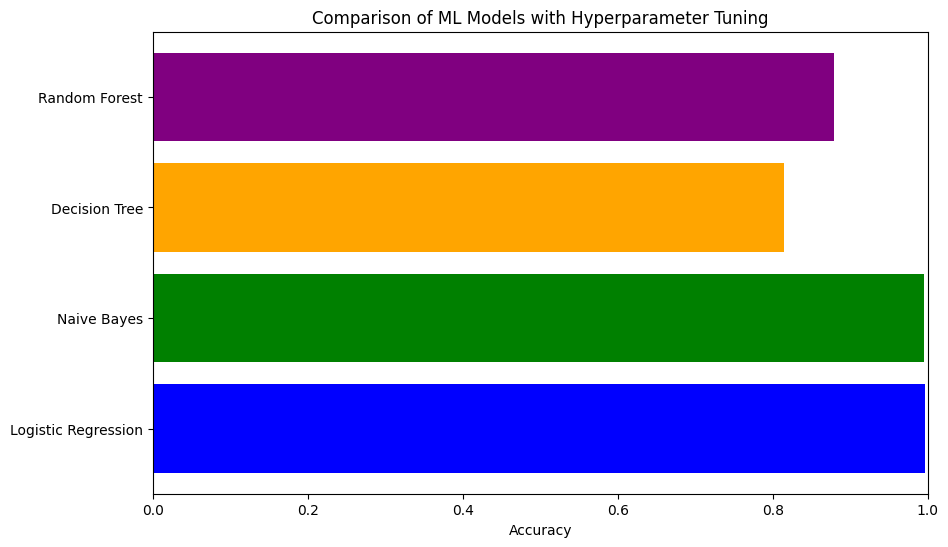

In [124]:
import matplotlib.pyplot as plt
classifiers = ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest']
accuracies = [evaluator_cv_lrs, evaluator_cv_nbs, evaluator_cv_dts, evaluator_cv_rfs]
plt.figure(figsize=(10, 6))
plt.barh(classifiers, accuracies, color=['blue', 'green', 'orange', 'purple'])
plt.xlabel('Accuracy')
plt.title('Comparison of ML Models with Hyperparameter Tuning')
plt.xlim(0, 1)

plt.show()


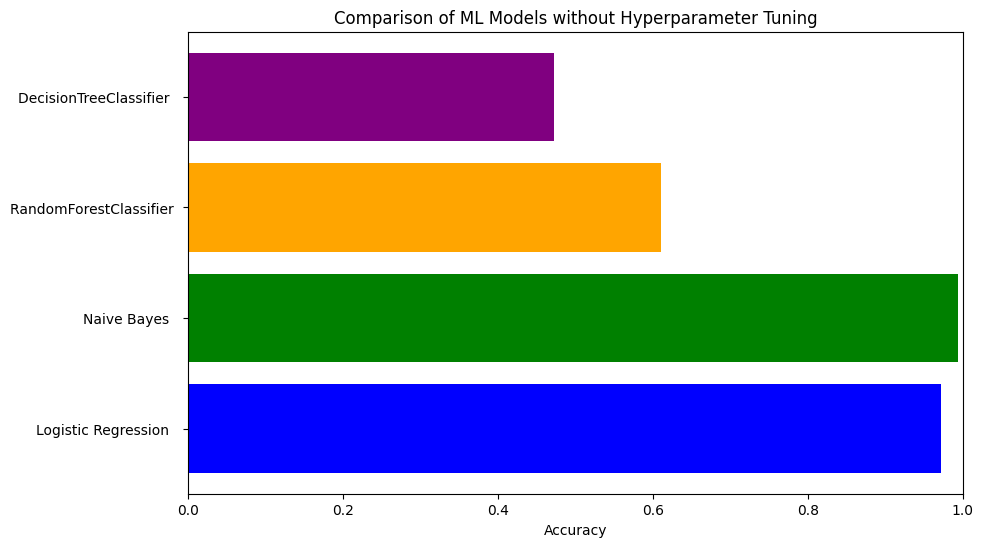

In [125]:
import matplotlib.pyplot as plt
classifierss = ['Logistic Regression  ', 'Naive Bayes  ', 'RandomForestClassifier ','DecisionTreeClassifier  ']
accuraciess = [evaluator_cv_lr, evaluator_cv_nb, evaluator_cv_rf, evaluator_cv_dt]
plt.figure(figsize=(10, 6))
plt.barh(classifierss, accuraciess, color=['blue', 'green', 'orange', 'purple'])
plt.xlabel('Accuracy')
plt.title('Comparison of ML Models without Hyperparameter Tuning')
plt.xlim(0, 1)

plt.show()

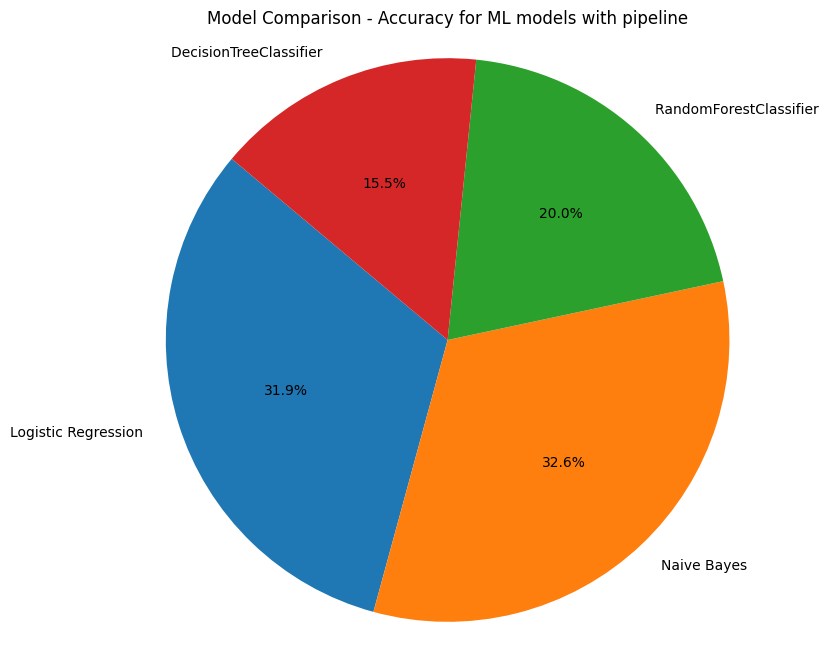

In [126]:
plt.figure(figsize=(8, 8))
plt.pie(accuraciess, labels=classifierss, autopct='%1.1f%%', startangle=140)
plt.title('Model Comparison - Accuracy for ML models with pipeline')
plt.axis('equal')
plt.show()


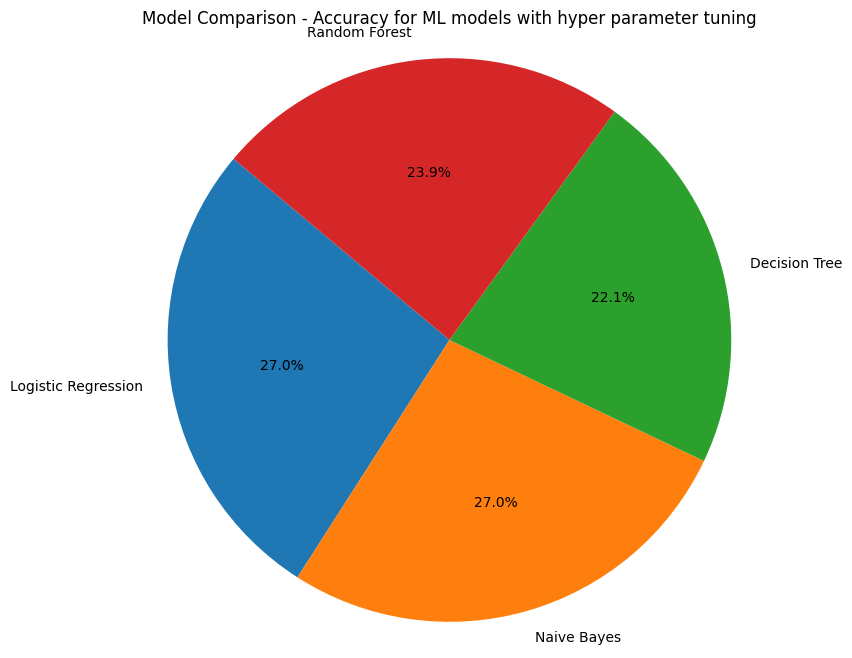

In [127]:
plt.figure(figsize=(8, 8))
plt.pie(accuracies, labels=classifiers, autopct='%1.1f%%', startangle=140)
plt.title('Model Comparison - Accuracy for ML models with hyper parameter tuning')
plt.axis('equal')
plt.show()

In [128]:
import pandas as pd
model_names = ['Logistic Regression  ', 'Naive Bayes  ', 'RandomForestClassifier ','DecisionTreeClassifier  ']
accuracies = [evaluator_cv_lr, evaluator_cv_nb, evaluator_cv_rf, evaluator_cv_dt]
tuned_accuracies =[evaluator_cv_lrs, evaluator_cv_nbs, evaluator_cv_dts,evaluator_cv_rfs]
accuracy_table = pd.DataFrame({
    'Model': model_names,
    'Accuracy (Without Tuning)': accuracies,
    'Accuracy (With Tuning)': tuned_accuracies
})
print(accuracy_table)

                      Model  Accuracy (Without Tuning)  Accuracy (With Tuning)
0     Logistic Regression                     0.971859                0.997092
1             Naive Bayes                     0.993791                0.995674
2   RandomForestClassifier                    0.610865                0.814572
3  DecisionTreeClassifier                     0.472947                0.879608


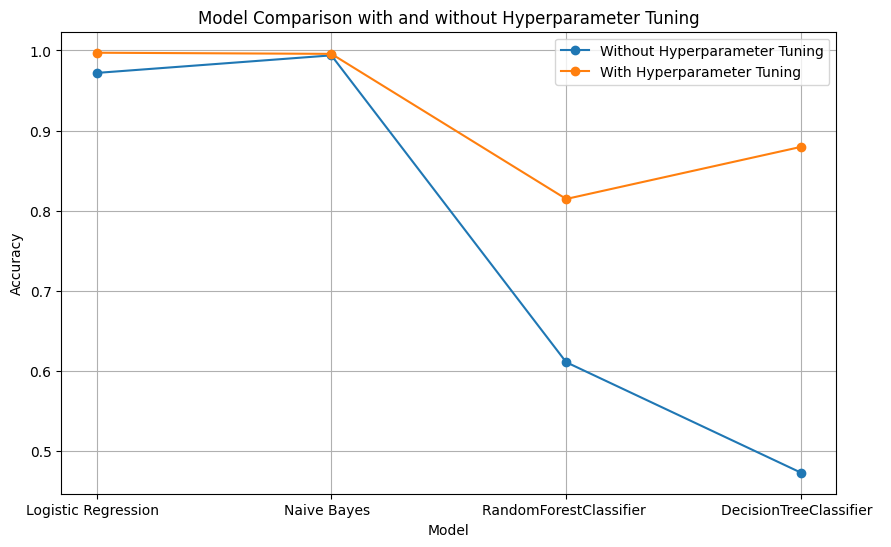

In [129]:
x = range(len(model_names))
plt.figure(figsize=(10, 6))
plt.plot(x, accuracies, marker='o', label='Without Hyperparameter Tuning')
plt.plot(x, tuned_accuracies, marker='o', label='With Hyperparameter Tuning')
plt.xticks(x, model_names)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison with and without Hyperparameter Tuning')
plt.legend()
plt.grid(True)
plt.show()
